In [1]:
import numpy as np
import cv2
from ex1_utils import gaussderiv, gausssmooth, show_flow
import matplotlib.pyplot as plt

### Lucas Kanade

In [2]:
def uniform_kernel(N):
    ker = np.ones((N,N))
    return ker

In [30]:
def lucaskanade(im1, im2, N, use_harris=True, harris_threshold=1e-7, sens=0.05, return_mask=False):
    """Simple non-pyramid LK optical flow estimation"""
    
    kernel = uniform_kernel(N)
    
    sigma = .6
    sigma = im1.shape[0] *  0.005
    im2 = gausssmooth(im2, 1)
    im1 = gausssmooth(im1, 1)

    dx_im1, dy_im1 = gaussderiv(im1, sigma)
    dx_im2, dy_im2 = gaussderiv(im2, sigma)

    # Get average derivatives
    I_x = (dx_im1 + dx_im2) / 2
    I_y = (dy_im1 + dy_im2) / 2
    I_t = im2 - im1
    I_t = gausssmooth(I_t, 1)

    I_xx = I_x * I_x
    I_yy = I_y * I_y
    I_xy = I_x * I_y
    I_xt = I_x * I_t
    I_yt = I_y * I_t
    
    # Harris reponse:
    S_xx = cv2.filter2D(I_xx, -1, kernel)
    S_yy = cv2.filter2D(I_yy, -1, kernel)
    S_xy = cv2.filter2D(I_xy, -1, kernel)
    
    Det = (S_xx * S_yy) - (S_xy ** 2)
    Trace = S_xx + S_yy
    
    R = Det - sens * (Trace ** 2)
    
    eps = 1e-10
    
    Det = (cv2.filter2D(I_xx, -1, kernel) * cv2.filter2D(I_yy, -1, kernel)) - (cv2.filter2D(I_xy, -1, kernel)**2)
    Det += eps

    u = - (
        cv2.filter2D(I_yy, -1, kernel) *
        cv2.filter2D(I_xt, -1, kernel)
        -
        cv2.filter2D(I_xy, -1, kernel) *
        cv2.filter2D(I_yt, -1, kernel)
    ) / Det 
    
    v = - (
        cv2.filter2D(I_xx, -1, kernel) *
        cv2.filter2D(I_yt, -1, kernel)
        -
        cv2.filter2D(I_xy, -1, kernel) *
        cv2.filter2D(I_xt, -1, kernel)
    ) / Det
    
    if use_harris:
        mask = R > harris_threshold
        u = u * mask
        v = v * mask
    
    if return_mask is False:
        return u, v 
    return u, v, mask

### Horn-Schunck

In [4]:
def laplacian():
    return np.array([[0, .25, 0], [.25, 0, .25], [0, .25, 0]])

In [5]:
def hornschunck(im1, im2, n_iters, lmbd, stop_thresh=None, u0=None, v0=None):
    
    sigma = im1.shape[0] *  0.005
    print(sigma)
    
    im1 = gausssmooth(im1, sigma)
    im2 = gausssmooth(im2, sigma)

    dx_im1, dy_im1 = gaussderiv(im1, sigma)
    dx_im2, dy_im2 = gaussderiv(im2, sigma)

    # Get average derivatives
    I_x = (dx_im1 + dx_im2) / 2
    I_y = (dy_im1 + dy_im2) / 2
    I_t = im2 - im1
    I_t = gausssmooth(I_t, sigma)
    
    lap = laplacian()
    
    if u0 is None and v0 is None:
        u = np.zeros_like(im1)
        v = np.zeros_like(im1)
    else:
        u = u0
        v = v0
    
    eps = 1e-10
    
    for i in range(n_iters):
        ua = cv2.filter2D(u, -1, lap)
        va = cv2.filter2D(v, -1, lap)
        
        P = I_x * ua + I_y * va + I_t
        D = lmbd + (I_x * I_x) + (I_y * I_y) + eps
        
        u = ua - I_x * (P / D)
        v = va - I_y * (P / D)
        
        # Check stopping criteria
        if i % 10 == 0 and stop_thresh is not None:

            diff = np.mean((u - ua)**2) + np.mean((v - va)**2)    # MSE
                        
            if diff < stop_thresh:
                print("Stopped at iter: ", i)
                break
        
    return u, v

## Testing (Req)

1.0


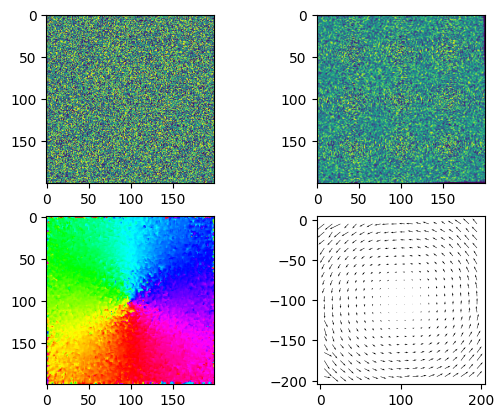

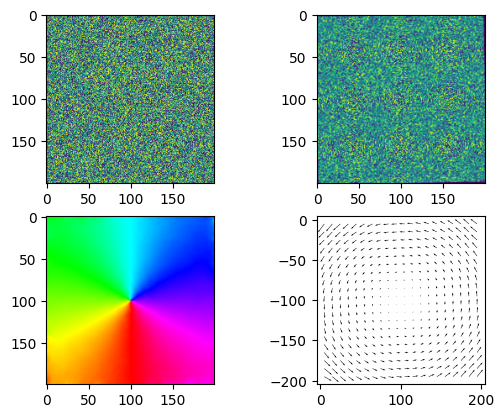

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from ex1_utils import rotate_image, show_flow
import time

im1=np.random.rand(200, 200)
im2=im1.copy()
im2=rotate_image(im2, 1)


U_lk, V_lk = lucaskanade(im1, im2, 3, use_harris=False)
U_hs, V_hs = hornschunck(im1, im2, 1000, 0.5)

fig1, ((ax1_11, ax1_12), (ax1_21, ax1_22)) = plt.subplots(2, 2)

ax1_11.imshow(im1)
ax1_12.imshow(im2)

show_flow(U_lk, V_lk, ax1_21, type='angle')
show_flow(U_lk, V_lk, ax1_22, type='field' , set_aspect=True)

# fig1.suptitle('Lucas Kanade Optical Flow')
fig2, ((ax2_11, ax2_12), (ax2_21, ax2_22)) = plt.subplots(2, 2)

ax2_11.imshow(im1)
ax2_12.imshow(im2)

show_flow(U_hs, V_hs, ax2_21, type='angle')
show_flow(U_hs, V_hs, ax2_22, type='field' , set_aspect=True)
# fig2.suptitle('Horn Schunck Optical Flow')
plt.show()

In [7]:
pairs = [("disparity/cporta_left.png", "disparity/cporta_right.png"), ("disparity/office_left.png", "disparity/office_right.png"), ("disparity/office2_left.png", "disparity/office2_right.png"), ("collision/00000001.jpg", "collision/00000005.jpg")]

def read_grayscale(path):
    img = cv2.imread(path)
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
    return img

2.125


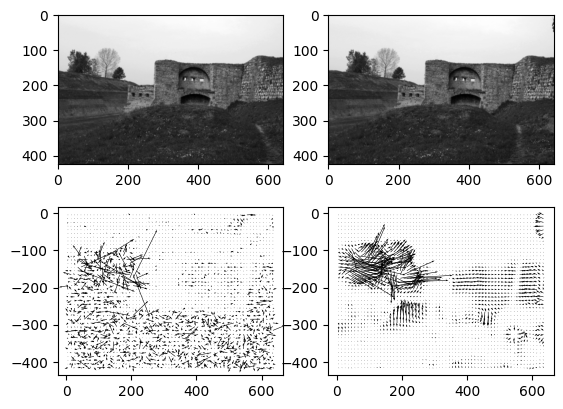

2.08


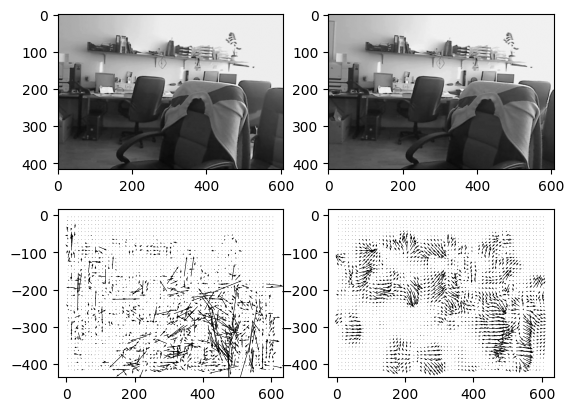

2.08


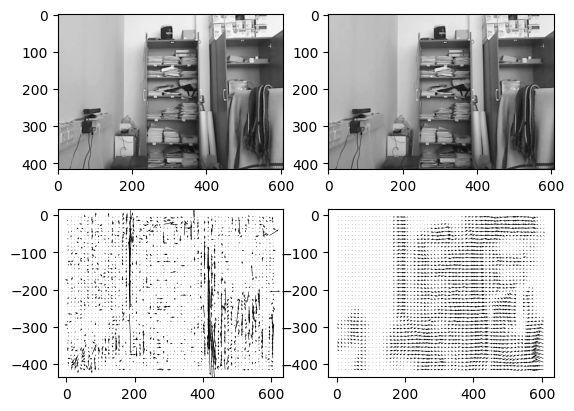

1.44


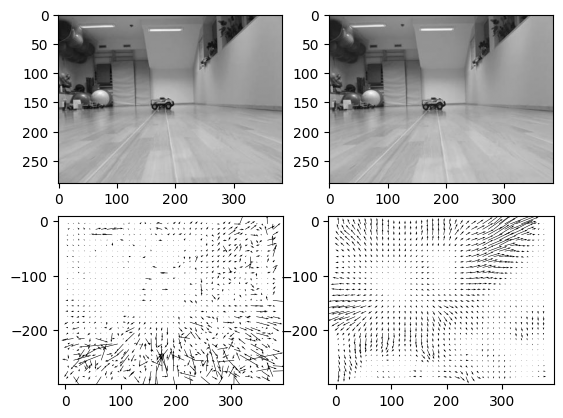

In [27]:
for im1, im2 in pairs:
    im1 = read_grayscale(im1)
    im2 = read_grayscale(im2)

    U_lk, V_lk = lucaskanade(im1, im2, 3, use_harris=False)
    U_hs, V_hs = hornschunck(im1, im2, 1000, .5)
    
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2)
    
    ax11.imshow(im1, cmap="gray")
    ax12.imshow(im2, cmap="gray")

    show_flow(U_lk, V_lk, ax21, type='field')
    show_flow(U_hs, V_hs, ax22, type='field')
    
    plt.show()


### LK - with harris and without

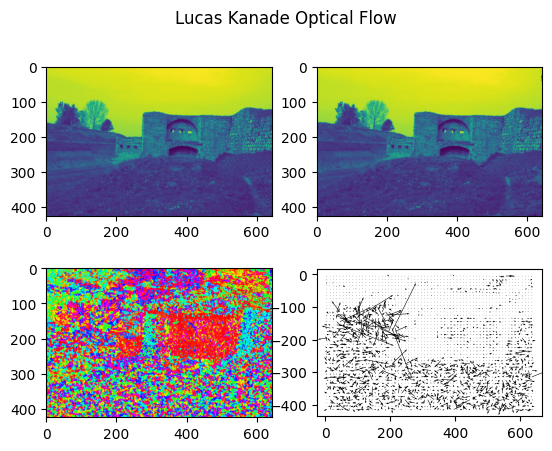

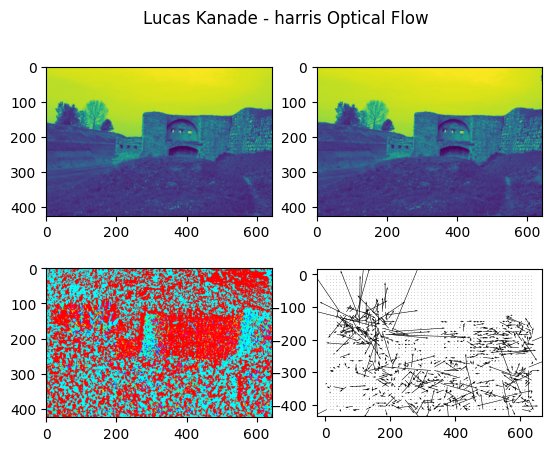

In [28]:
im1 = read_grayscale(pairs[0][0])
im2 = read_grayscale(pairs[0][1])

U_lk, V_lk = lucaskanade(im1, im2, 3, use_harris=False)
U_lkh, V_lkh = lucaskanade(im1, im2, 3, use_harris=True, harris_threshold=1e-7, sens=0.07)

fig1, ((ax1_11, ax1_12), (ax1_21, ax1_22)) =plt.subplots(2, 2)
ax1_11.imshow(im1)
ax1_12.imshow(im2)

show_flow(U_lk, V_lk, ax1_21, type='angle')
show_flow(U_lk, V_lk, ax1_22, type='field' , set_aspect=True)

fig1.suptitle('Lucas Kanade Optical Flow')
fig2, ((ax2_11, ax2_12), (ax2_21, ax2_22)) =plt.subplots(2, 2)

ax2_11.imshow(im1)
ax2_12.imshow(im2)

show_flow(U_lkh, V_lkh, ax2_21, type='angle')
show_flow(U_lkh, V_lkh, ax2_22, type='field' , set_aspect=True)
fig2.suptitle('Lucas Kanade - harris Optical Flow')
plt.show()


Text(0.5, 0.98, 'Lucas Kanade Optical Flow')

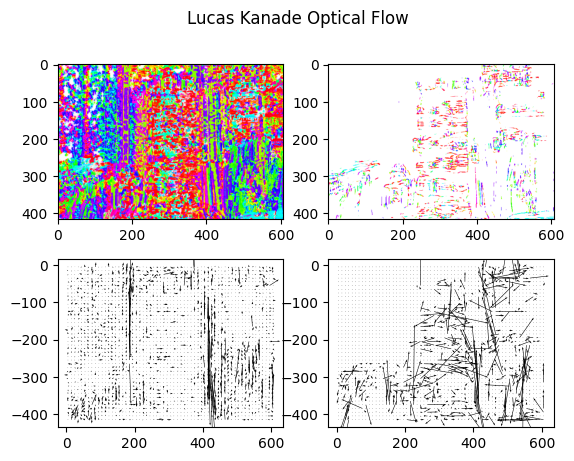

In [ ]:
im1 = read_grayscale(pairs[2][0])
im2 = read_grayscale(pairs[2][1])

U_lk, V_lk = lucaskanade(im1, im2, 3, use_harris=False)
U_lkh, V_lkh, mask = lucaskanade(im1, im2, 3, use_harris=True, harris_threshold=1e-7, sens=0.07, return_mask=True)

fig1, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2)


show_flow(U_lk, V_lk, ax11, type='angle_magnitude')
show_flow(U_lkh, V_lkh, ax12, type='angle_magnitude')
show_flow(U_lk, V_lk, ax21, type="field")
show_flow(U_lkh, V_lkh, ax22, type="field")



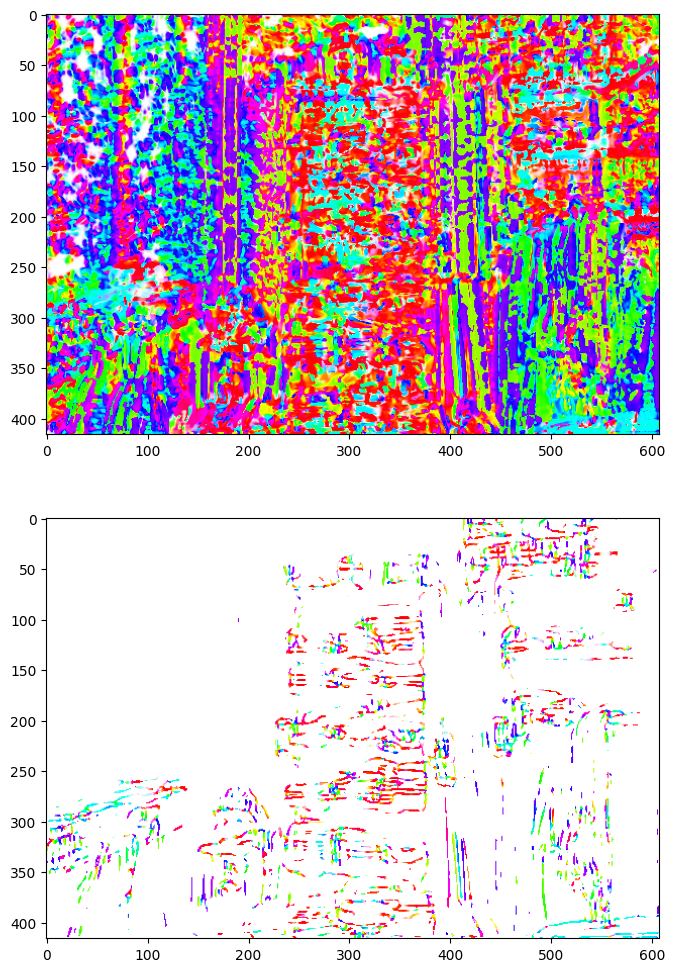

In [9]:
fig, ax = plt.subplots(2,1, figsize=(8,12))

show_flow(U_lk, V_lk, ax[0], type="angle_magnitude")
show_flow(U_lkh, V_lkh, ax[1], type="angle_magnitude")

### Test on other images (3 pairs)

In [10]:

# for p1, p2 in pairs:
#     im1 = cv2.imread(p1)
#     im2 = cv2.imread(p2)

#     im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
#     im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


#     U_lk, V_lk = lucaskanade(im1, im2, 6)
#     U_hs, V_hs = hornschunck(im1, im2, n_iters=1000, lmbd=.5)
    
#     fig1, ((ax1_11, ax1_12), (ax1_21, ax1_22)) = plt.subplots(2, 2, figsize=(14, 10))

#     ax1_11.imshow(im1)
#     ax1_12.imshow(im2)

#     show_flow(U_lk, V_lk, ax1_21, type='angle')
#     show_flow(U_lk, V_lk, ax1_22, type='field' , set_aspect=True)

#     fig1.suptitle('Lucas Kanade Optical Flow')
#     fig2, ((ax2_11, ax2_12), (ax2_21, ax2_22)) = plt.subplots(2, 2, figsize=(14, 10))

#     ax2_11.imshow(im1)
#     ax2_12.imshow(im2)

#     show_flow(U_hs, V_hs, ax2_21, type='angle')
#     show_flow(U_hs, V_hs, ax2_22, type='field' , set_aspect=True)
#     fig2.suptitle('Horn Schunck Optical Flow')
#     plt.show()

## Timing

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from ex1_utils import rotate_image, show_flow
import time

im1 = read_grayscale(pairs[2][0])
im2 = read_grayscale(pairs[2][1])

# im1=np.random.rand(200, 200)
# im2=im1.copy()
# im2=rotate_image(im2, 1)
start = time.time()
U_lk, V_lk = lucaskanade(im1, im2, 3)
lk = time.time()

stop_thresh = 1e-5

U_hs, V_hs = hornschunck(im1, im2, 1000, .5, stop_thresh)
hs = time.time()

print("Lk took ", lk-start)
print("HS took ", hs - lk)

start = time.time()
U_lk, V_lk = lucaskanade(im1, im2, 3)
U_hss, V_hss = hornschunck(im1, im2, 1000, .5, stop_thresh, U_lk, V_lk)
end = time.time()

print("Combined took", end-start)


2.08
Stopped at iter:  560
Lk took  0.08874249458312988
HS took  8.477157831192017
2.08
Stopped at iter:  480
Combined took 6.084159851074219


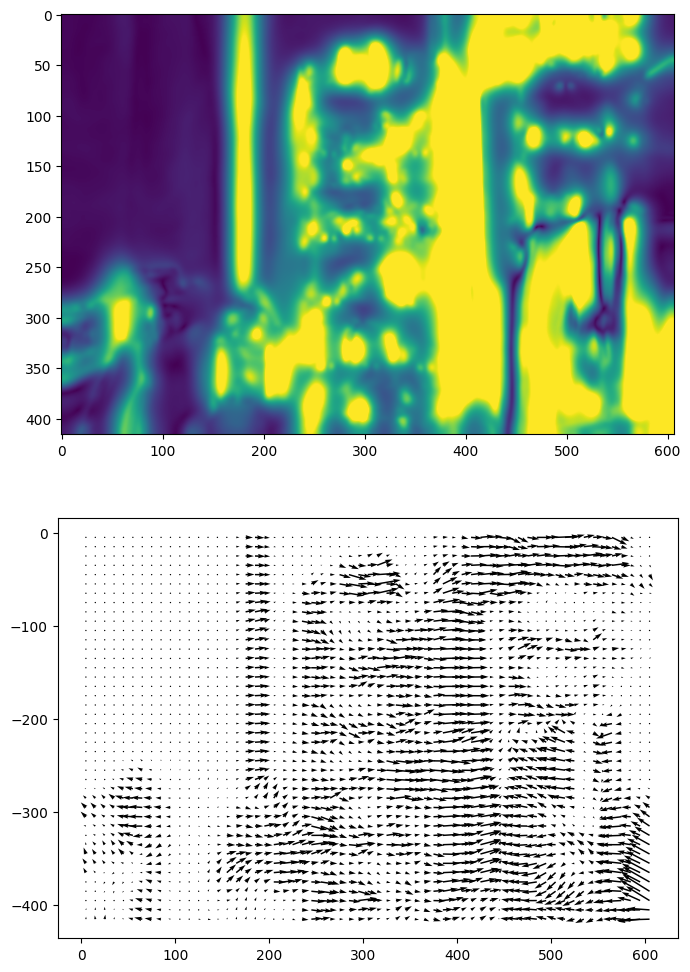

In [12]:
fig, ax = plt.subplots(2,1, figsize=(8,12))

show_flow(U_hs, V_hs, ax[0], type="magnitude")
show_flow(U_hss, V_hss, ax[1], type="field")

### Pyramid LK

In [13]:
pyramid = []
def build_pyramid(image, levels):
    """Gives a list of downsampled images using cv2 pyrDown"""
    pyramid = [image]
    for _ in range(1, levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid            

In [14]:
def upsample_optical_flow(flow, shape):
    """Resize flow 1 level up"""
    h, w = shape
    flow = cv2.resize(flow, (w, h), interpolation=cv2.INTER_LINEAR) * 2
    return flow

In [15]:
def pyramidal_lucaskanade(im1, im2, N, levels=3, use_harris=True, harris_threshold=1e-7, sens=0.05, layer_reps=1):
    pyr1 = build_pyramid(im1, levels)
    pyr2 = build_pyramid(im2, levels)

    u = np.zeros_like(pyr1[-1])
    v = np.zeros_like(pyr1[-1])

    for level in range(levels)[::-1]:
        im1_lvl = pyr1[level]
        im2_lvl = pyr2[level]
        
        # Upsample previous flow estimate
        if level < levels - 1:
            u = upsample_optical_flow(u, im1_lvl.shape[:2])
            v = upsample_optical_flow(v, im1_lvl.shape[:2])

        h, w = im2_lvl.shape
        
        X, Y = np.meshgrid(np.arange(w), np.arange(h))  # Normal pixel indices
        offset_hor = X + u  # Add offsets
        offset_ver = Y + v        
        
        # Warp
        im2_warped = cv2.remap(im2_lvl, 
                            (offset_hor).astype(np.float32),
                            (offset_ver).astype(np.float32),
                            interpolation=cv2.INTER_LINEAR)

        for rep in range(layer_reps):
            du, dv = lucaskanade(im1_lvl, im2_warped, N, use_harris, harris_threshold, sens)
            
            u += du
            v += dv

    return u, v

In [16]:
im1 = read_grayscale(pairs[1][0])
im2 = read_grayscale(pairs[1][1])


u, v = pyramidal_lucaskanade(im1, im2, 3, use_harris=True, layer_reps=2)

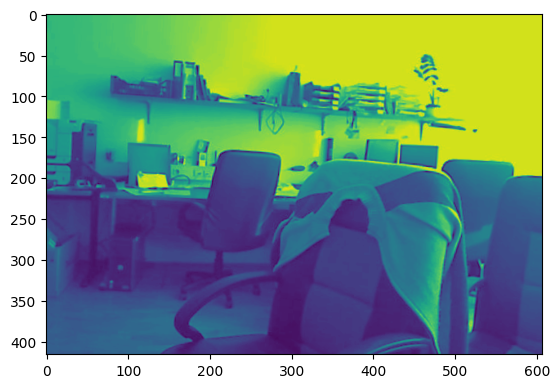

In [17]:
plt.imshow(im1)

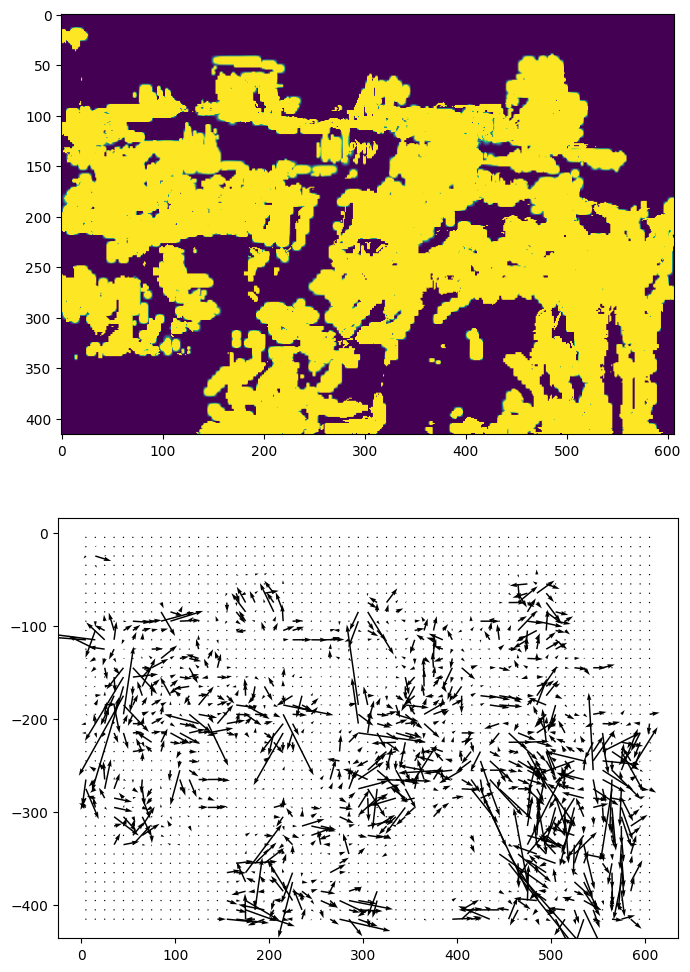

In [18]:

fig, ax = plt.subplots(2,1, figsize=(8,12))

show_flow(u, v, ax[0], type="magnitude")
show_flow(u, v, ax[1], type="field")